# Use a k-Nearest Neighbors (kNN) method as model prediction  

In [1]:
import os
import sys
nb_dir = "./include_files"
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
%matplotlib inline
import h5py as h5

from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.style as style
style.use('fivethirtyeight')

# plt.style.use("./include_files/marius.mplstyle")
# fontSize = 15
# lineWidth = 1.5

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', 
          u'#7f7f7f', u'#bcbd22', u'#17becf']

## Load the data

In [2]:
data = np.load( "data/NN_feature_data_N=5e4.npz" )

for key in data.files:
    code = key + ' = data["' + key + '"]'
    print(code)
    exec( code )

print( "\nSize of the input feature vector: ", data_input.shape, len(name_input) )
print( "Size of the output vector: ", data_output.shape )

num_features = data_input.shape[1]

data_input = data["data_input"]
data_output = data["data_output"]
name_input = data["name_input"]
name_output = data["name_output"]

Size of the input feature vector:  (50000, 10) 10
Size of the output vector:  (50000, 1)


## 1. Split the data into train/test and scale it to min-max values

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split( data_input, data_output, \
                                                                    test_size=.4, random_state=0 )
print( "Size of training set: %i" % raw_x_train.shape[0] )
print( "Size of testing  set: %i" % raw_x_test.shape[0] )

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_train = x_scaler.fit_transform( raw_x_train )
x_test  = x_scaler.transform( raw_x_test )

y_train = y_scaler.fit_transform( raw_y_train )
y_test  = y_scaler.transform( raw_y_test )

Size of training set: 30000
Size of testing  set: 20000


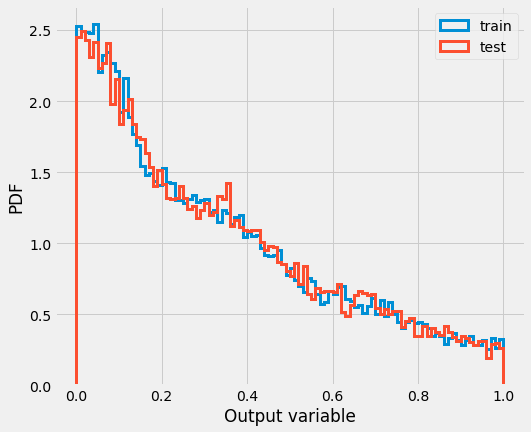

In [4]:
# check the PDF of the training and test samples for the output variable
fig1 = plt.figure( figsize=(1*7.5,1*6.5) )

bins = np.linspace(0.,1.,101)
plt.xlabel( "Output variable" )
plt.ylabel( "PDF" )
discard = plt.hist( y_train, bins=bins, density=True, histtype='step', lw=3, label="train" )
discard = plt.hist( y_test, bins=bins, density=True, histtype='step', lw=3, label="test" )
plt.legend()

## 3. Create the complexity curve -- vary the k hyperparameter to find its optimal value 

This can be performed using `sklearn`'s `GridSearchCV` function, but for this simple case it is fun to write a manual code.

In [5]:
from sklearn.metrics import mean_squared_error

def complexity_curve( k_list, knn_model, x_train, x_test, y_train, y_test ):
    score_train = []
    score_test  = []
    for k in k_list:
        print( k, end="  " )
        knn = knn_model(k, algorithm='kd_tree')
        knn.fit(x_train, y_train)
        
        score_train.append( mean_squared_error(knn.predict(x_train), y_train) )
        score_test.append( mean_squared_error(knn.predict(x_test), y_test) )
    
    return score_train, score_test

def plot_complexity_curve(k_list, score_train, score_test):
    fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
    gs = gridspec.GridSpec( 1, 1 )
    ax = plt.subplot( gs[0] )
    
    ax.plot(k_list, score_train, c=colors[0], label='Training set')
    ax.plot(k_list, score_test, c=colors[1], label='Testing set')

    ax.set(title='k-NN with Different Values for $k$',
           xlabel='Number of Neighbors',
           ylabel='mean squared error')
    ax.legend()

5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95  100  

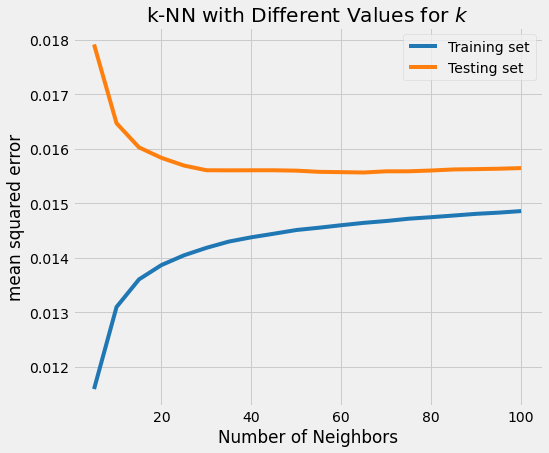

In [6]:
from sklearn.neighbors import KNeighborsRegressor

k_list = 5 * np.arange( 1, 21 )
score_train, score_test = complexity_curve( k_list, KNeighborsRegressor, x_train, x_test, 
                                           y_train, y_test )
plot_complexity_curve(k_list, score_train, score_test)

## Calculate the model prediction for the optimal k value

In [7]:
k_optimal = k_list[ np.argmin(score_test) ]
print( "Optimal k value = %i" % k_optimal )
print( "Test MSE = %.5f" % np.min(score_test) )


# Construct the optimal model
knn = KNeighborsRegressor(k_optimal)
knn.fit( x_train, y_train )

# pred_y_train = knn.predict( x_train[:N] )
pred_y_test  = knn.predict( x_test )
SE = (pred_y_test - y_test)**2  # squared error for each test entry


Optimal k value = 65
Test MSE = 0.01556


In [8]:
# saved the test set predictions to a file
outfile = "data_output/kNN/pred_y_test_full_model.npz"
np.savez_compressed( outfile, pred_y_test=pred_y_test )

## Compare the PDF of the true output and predicted values  

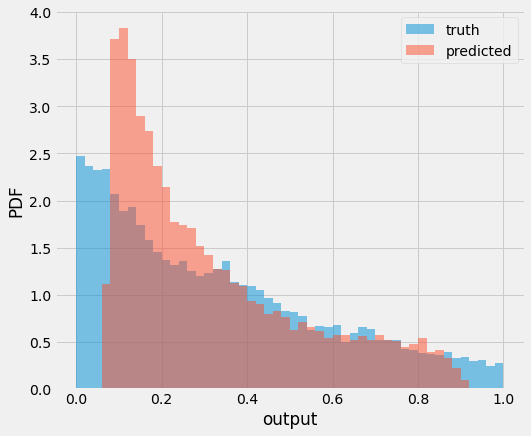

In [9]:
bins = np.linspace(0.,1.,51)

fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.xlabel( "output" )
plt.ylabel( "PDF" )

plt.hist( y_test, bins=bins, density=True, alpha=0.5, label="truth")
plt.hist( pred_y_test, bins=bins, density=True, alpha=0.5, label="predicted")
plt.legend()

As expected, we find that the ML cannot fully reproduce the output PDF, failing to obtain the values in the tails of the distribution. This is to be expected since **it is the tendency of ML to make predictions towards the mean value.**

## Inspect how the MSE varies as a function of predicted output  



Mean square error: 1.556e-02   1.556e-02


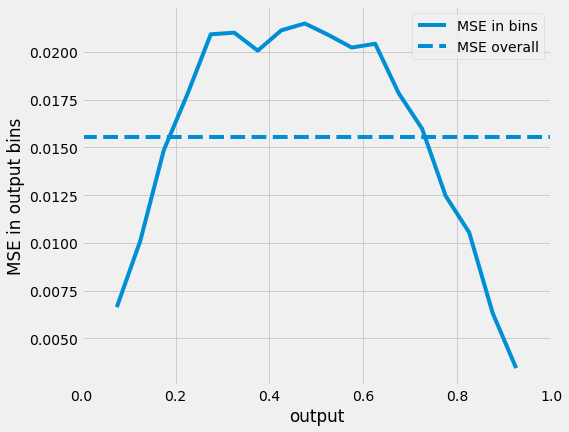

In [10]:
def running_mean(x, y, x_bins):
    """Calculates the mean y in bins of x."""
    mean = []
    for i in range( len(x_bins)-1 ):
        sel = (x>x_bins[i]) * (x<=x_bins[i+1])
        if sel.sum()>10: mean.append( y[sel].mean() )  # when enough point inside the bin
        else: mean.append( 0 )
    return np.array(mean)

MSE = SE.mean()
print( "Mean square error: %.3e   %.3e" % (MSE, np.min(score_test)) )

fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.xlabel( "output" )
plt.ylabel( "MSE in output bins" )

# calculate the error as a function of target value
target_bins = np.linspace( 0., 1., 21 )
target_vals = 0.5 * (target_bins[1:] + target_bins[:-1])
MSE_bins    = running_mean( pred_y_test[:,0], SE[:,0], target_bins )

plt.xlim( [0.,1.])
valid = MSE_bins > 0.
line, = plt.plot( target_vals[valid], MSE_bins[valid], label="MSE in bins" )
plt.hlines( MSE, 0., 1., ls='--', color=line.get_color(), label="MSE overall" )
plt.legend()

MSE depends on the output value and it is largest for predicted values close to the middle of output range. 

## 4. Calculate which features dominate the prediction

In [11]:
from sklearn.inspection import permutation_importance

Nmax = 5000  # use a subset of the test set to speed up the calculation
perm_imp = permutation_importance( knn, x_test[:Nmax], y_test[:Nmax], n_repeats=5, random_state=0, \
                                  scoring='neg_mean_squared_error' )

In [12]:
# save the permutation importance to a file
outfile = "data_output/kNN/permutation_importance_test_full_model.npz"
np.savez_compressed( outfile, importances_mean=perm_imp.importances_mean, importances_std=perm_imp.importances_std, \
                   importances=perm_imp.importances)

List of feature indexes sorted by importance:  [7 1 2 6 0 8 3 4 5 9]
List of feature names   sorted by importance:  ['vel. radial' 'N_sat 1.e6' 'N_sat 1.e7' 'vel. tan.' 'M_star' 'mean L'
 'N_sat 1.e8' 'N_sat 1.e9' 'N_sat 1.e10' 'mean d']


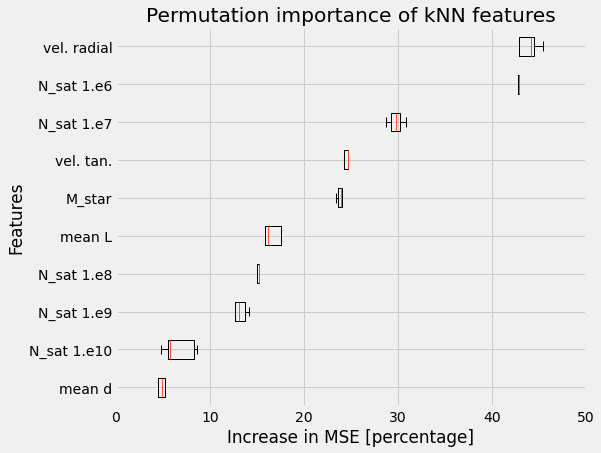

In [13]:
# make a box-plot of the permutation importance for features
perm_sorted_idx = perm_imp.importances_mean.argsort()
print( "List of feature indexes sorted by importance: ", perm_sorted_idx[::-1] )
print( "List of feature names   sorted by importance: ", name_input[perm_sorted_idx][::-1] )

fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.title( "Permutation importance of kNN features" )
plt.ylabel( "Features" )
plt.xlabel( "Increase in MSE [percentage]" )
plt.xlim( [0,50] )
d = plt.boxplot( perm_imp.importances[perm_sorted_idx].T*100./MSE, vert=False, \
            labels=name_input[perm_sorted_idx], showfliers=False, whis=0.75 )

## 5. Compare the feature importance when removing the high multicollinearity features  

In this case, there is only one high multicollinearity feature: feature 9 = 'mean L'.  

Normally we would need to calculate the complexity curve of the kNN model again to find the optimal hyperparameter k, but for simplicity and since we only remove 1 out of 10 features, we can as well use the previous optimal value for k.

In [14]:
sel = np.ones( num_features, bool )
sel[8] = False
print( "Reruning the kNN pipeline after removing the features:", name_input[~sel] )

# define the new features after removing the high multicollinearity features 
# noMC = no multicollinearity
name_input_noMC = name_input[sel]
x_train_noMC = x_train[:,sel]
x_test_noMC  = x_test[:,sel]

knn_noMC = KNeighborsRegressor(k_optimal)
knn_noMC.fit( x_train_noMC, y_train )

MSE_noMC = mean_squared_error( knn_noMC.predict( x_test_noMC ), y_test )

print( "MSE np high MC features: \t%.5f" % MSE_noMC )
print( "MSE full       features: \t%.5f" % MSE )
print( "Increase in MSE:         \t%.5f (%.1f %%)" % (MSE_noMC-MSE, (MSE_noMC-MSE)*100./MSE) )

Reruning the kNN pipeline after removing the features: ['mean L']
MSE np high MC features: 	0.01570
MSE full       features: 	0.01556
Increase in MSE:         	0.00014 (0.9 %)


In [15]:
perm_imp_noMC = permutation_importance( knn_noMC, x_test_noMC[:Nmax], y_test[:Nmax], n_repeats=5, random_state=0, \
                                  scoring='neg_mean_squared_error' )

List of feature indexes sorted by importance:  [1 7 6 2 0 3 4 8 5]
List of feature names   sorted by importance:  ['N_sat 1.e6' 'vel. radial' 'vel. tan.' 'N_sat 1.e7' 'M_star' 'N_sat 1.e8'
 'N_sat 1.e9' 'mean d' 'N_sat 1.e10']


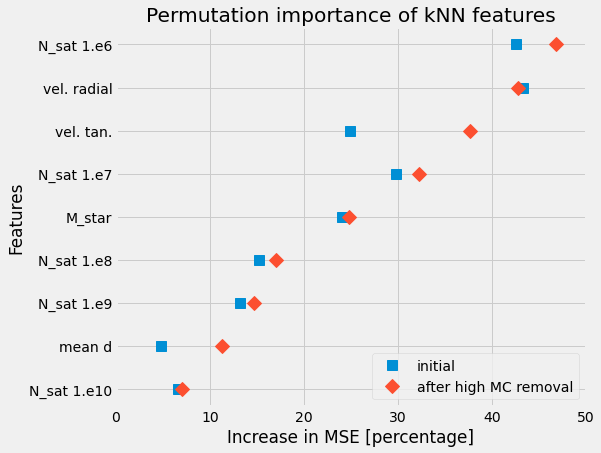

In [16]:
# order of feature importance for the no multicollinearity case
perm_sorted_idx_noMC = perm_imp_noMC.importances_mean.argsort()
print( "List of feature indexes sorted by importance: ", perm_sorted_idx_noMC[::-1] )
print( "List of feature names   sorted by importance: ", name_input_noMC[perm_sorted_idx_noMC][::-1] )

fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.title( "Permutation importance of kNN features" )
plt.ylabel( "Features" )
plt.xlabel( "Increase in MSE [percentage]" )
plt.xlim( [0,50] )
plt.yticks( np.arange(9), name_input_noMC[perm_sorted_idx_noMC] )

plt.plot( perm_imp.importances_mean[sel][perm_sorted_idx_noMC].T*100./MSE, np.arange(9), 's', ms=10, label="initial" )
plt.plot( perm_imp_noMC.importances_mean[perm_sorted_idx_noMC].T*100./MSE_noMC, np.arange(9), 'D', ms=10, \
         label="after high MC removal" )
plt.legend( loc=4 )

# d = plt.boxplot( perm_imp.importances[sel][perm_sorted_idx_noMC].T*100./MSE, vert=False, \
#             labels=[""]*9, showfliers=False, whis=0.75 )
# d = plt.boxplot( perm_imp_noMC.importances[perm_sorted_idx_noMC].T*100./MSE_noMC, vert=False, \
#             labels=name_input_noMC[perm_sorted_idx_noMC], showfliers=False, whis=0.75 )

Removing the high multicollinearity feature leads to increased importance scores for most features. As expected, the largest increase is for the features that showed high correlation with the removed feature. These are: 'vel. tan.' and 'mean d'. 

## 6. Can we achieve similar accuracy using a simpler model?  

One way to simplify the model is to count all the galaxies orbiting the Milky Way as a single feature. Up to now we had separate counts of small, intermediate, and large galaxies (we actually have 5 such counts). *This is similar to counting all the bees and not splitting them according to their size.*

In [17]:
new_feature = data_input[:,1:1+5].sum(axis=1)
data_input_new = np.column_stack( (data_input[:,0],new_feature,data_input[:,6:]) )
name_input_new = np.hstack( (name_input[0], "N_sat all", name_input[6:]) )

print( "The new reduced data features:", name_input_new )

The new reduced data features: ['M_star' 'N_sat all' 'vel. tan.' 'vel. radial' 'mean L' 'mean d']


Let us split the data again into a training and test set. Since we use the same random state as for the first "full" case, the same entries will be associated to the training and the test sets.  

We also need to rescale the input features. For the output feature, we can use the ones rescaled before since we haven't modified the output.

In [18]:
raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split( data_input_new, data_output, \
                                                                    test_size=.4, random_state=0 )
x_scaler_new = MinMaxScaler()

x_train_new = x_scaler_new.fit_transform( raw_x_train )
x_test_new  = x_scaler_new.transform( raw_x_test )

Given the considerable change in the number of features, let us **find the optimal value of the hyperparameter k again**.

5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95  100  
Optimal k value = 60
Test MSE = 0.01564



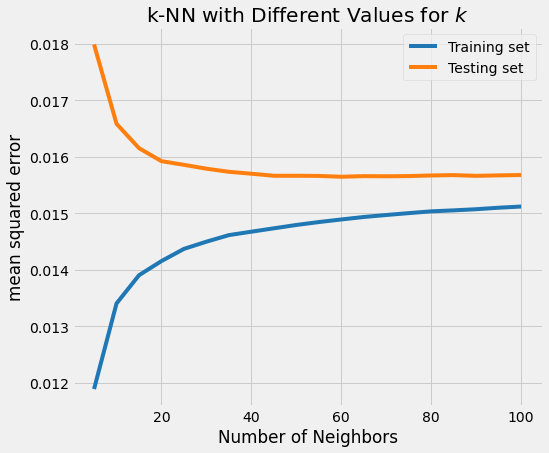

In [19]:
score_train_new, score_test_new = complexity_curve( k_list, KNeighborsRegressor, x_train_new, x_test_new, 
                                           y_train, y_test )
plot_complexity_curve(k_list, score_train_new, score_test_new)

k_optimal_new = k_list[ np.argmin(score_test_new) ]
print( "\nOptimal k value = %i" % k_optimal_new )
print( "Test MSE = %.5f\n" % np.min(score_test_new) )


In [20]:
MSE_new = np.min(score_test_new)

print( "MSE reduced features: \t%.5f" % MSE_new )
print( "MSE full    features: \t%.5f" % MSE )
print( "Increase in MSE:      \t%.5f (%.1f %%)" % (MSE_new-MSE, (MSE_new-MSE)*100./MSE) )

MSE reduced features: 	0.01564
MSE full    features: 	0.01556
Increase in MSE:      	0.00008 (0.5 %)


Basically the model does almost as well when considering only a single feature that counts all the galaxies orbiting the Milky Way. There is only a minimal increase in MSE of 0.5% when splitting the galaxy count according to the size of the galaxies.

### What is the feature importance of this simplified model

In [21]:
knn_new = KNeighborsRegressor(k_optimal_new)
knn_new.fit( x_train_new, y_train )

KNeighborsRegressor(n_neighbors=60)

In [22]:
# saved the test set predictions to a file
outfile = "data_output/kNN/pred_y_test_Nsat.npz"
np.savez_compressed( outfile, pred_y_test=knn_new.predict(x_test_new) )

In [23]:
perm_imp_new = permutation_importance( knn_new, x_test_new[:Nmax], y_test[:Nmax], n_repeats=5, random_state=0, \
                                  scoring='neg_mean_squared_error' )

In [24]:
# save the permutation importance to a file
outfile = "data_output/kNN/permutation_importance_test_Nsat.npz"
np.savez_compressed( outfile, importances_mean=perm_imp_new.importances_mean, importances_std=perm_imp_new.importances_std, \
                   importances=perm_imp_new.importances)

To compare to the permutation importance of the complex model, let us calculate the increase in MSE when **permuting at the same time all the 5 features** that include the galaxy count. 

In [25]:
# shuffle all 5 features at the same time
shuffled_indices = np.arange(Nmax)
x_test_shuffled = x_test[:Nmax].copy()
for i in range(1,6):
    np.random.shuffle( shuffled_indices )
    x_test_shuffled[:,i] = x_test_shuffled[:,i][shuffled_indices]

# calculate the increase in MSE
MSE_Nsat_shuffled = mean_squared_error( knn.predict( x_test_shuffled ), y_test[:Nmax] )
print( "Increase in MSE when permuting all features containing satellite counts:  %.5f (%.1f %%)" % \
      (MSE_Nsat_shuffled-MSE, (MSE_Nsat_shuffled-MSE)*100./MSE ) )

Increase in MSE when permuting all features containing satellite counts:  0.02662 (171.0 %)


List of feature indexes sorted by importance:  [1 3 2 4 0 5]
List of feature names   sorted by importance:  ['N_sat all' 'vel. radial' 'vel. tan.' 'mean L' 'M_star' 'mean d']


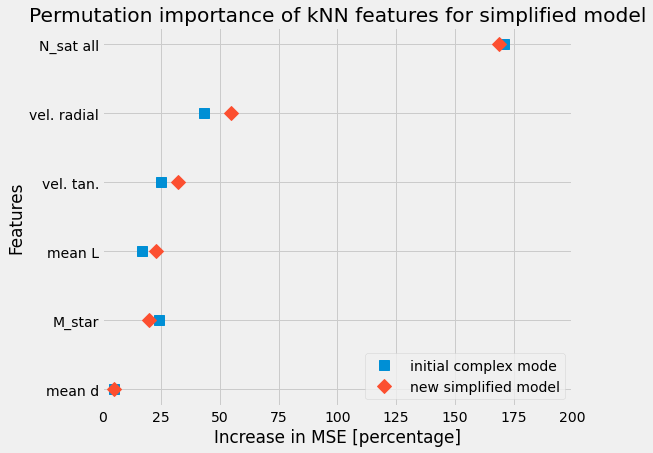

In [26]:
# order of feature importance for the no multicollinearity case
perm_sorted_idx_new = perm_imp_new.importances_mean.argsort()
print( "List of feature indexes sorted by importance: ", perm_sorted_idx_new[::-1] )
print( "List of feature names   sorted by importance: ", name_input_new[perm_sorted_idx_new][::-1] )

fig1 = plt.figure( figsize=(1*7.5,1*6.5) )
plt.title( "Permutation importance of kNN features for simplified model" )
plt.ylabel( "Features" )
plt.xlabel( "Increase in MSE [percentage]" )
plt.xlim( [0,200] )
plt.yticks( np.arange(6), name_input_new[perm_sorted_idx_new] )

mean_importances_complex = np.hstack( (perm_imp.importances_mean[0], MSE_Nsat_shuffled-MSE, \
                                        perm_imp.importances_mean[6:]) )

plt.plot( mean_importances_complex[perm_sorted_idx_new].T*100./MSE, np.arange(6), 's', ms=10, \
         label="initial complex mode" )
plt.plot( perm_imp_new.importances_mean[perm_sorted_idx_new].T*100./MSE_new, np.arange(6), 'D', ms=10, \
         label="new simplified model" )
plt.legend( loc=4 )